In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import collections

pd.options.mode.chained_assignment = None  # default='warn'
from statsmodels.stats import multitest
from scipy import stats

## Gene-level ReadZs from 10Xv3 sequencing correlations with MOp MERFISH

In [2]:
#Pull directly from gene_cell table because I want to collapse per mouse (2 mice total)
mop_df = pd.read_csv('../outputs/gene_cell/MOp_peripheral_ReadZs_gene_ontology.csv')

gb_cols = ['mouse','gene','ontology']

#filter SRRS results to
#1. Drop gene/cells which have fewer than 5 gene spots of interest
#2. Drop gene/cell-type/mouse with fewer than 20 cells
mop_df = mop_df[mop_df['num_gene_spots'].ge(5)]
mop_df = mop_df.groupby(gb_cols).filter(lambda g: len(g) >= 20)

#aggregate by mouse (over all slices)
#Calculate z from Lyapunov CLT for each gene in each sample
mop_agg_df = mop_df.groupby(gb_cols).agg(
    num_cells = ('cell_id','nunique'),
    num_slices = ('sample','nunique'),
    med_gene_spots = ('num_gene_spots','median'),
    med_spots = ('num_spots','median'),
    med_score = ('score','median'),
    score_sum = ('score','sum'),
    var_sum = ('variance','sum'),
).reset_index()

mop_agg_df['z'] = mop_agg_df['score_sum']/np.sqrt(mop_agg_df['var_sum'])

#Calculate two-sided p and BH correct ps
p_onesided = stats.norm.cdf(mop_agg_df['z'])
mop_agg_df['p'] = 2*np.minimum(p_onesided, 1-p_onesided)

alpha = 0.05

_,adj_p,_,_ = multitest.multipletests(
    mop_agg_df['p'],
    alpha = alpha,
    method = 'fdr_bh',
)
mop_agg_df['bh_p'] = adj_p
mop_agg_df = mop_agg_df.rename(columns={'mouse':'merfish_mouse'})
mop_agg_df

,merfish_mouse,gene,ontology,num_cells,num_slices,med_gene_spots,med_spots,med_score,score_sum,var_sum,z,p,bh_p
0,1,Acta2,L2/3 IT,991,5,5.0,695.0,0.102431,91.602118,122.242160,8.285048,2.220446e-16,8.804734e-16
1,1,Acta2,L5 ET,106,3,5.0,888.5,0.095434,9.724163,13.084333,2.688292,7.181856e-03,1.179307e-02
2,1,Acta2,L5 IT,817,5,6.0,836.0,0.125850,92.051336,97.079655,9.342562,0.000000e+00,0.000000e+00
3,1,Acta2,L6 CT,265,3,5.0,516.0,0.176113,39.580953,33.029954,6.887035,5.696776e-12,1.891902e-11
4,1,Acta2,L6 IT,448,5,5.0,781.5,0.167048,69.549196,54.999854,9.378024,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2509,2,Wnt7b,L5 ET,562,6,10.0,869.0,0.054671,25.664760,46.654497,3.757426,1.716700e-04,3.422509e-04
2510,2,Wnt7b,L5 IT,4906,6,18.0,636.0,0.052561,252.284730,275.239351,15.206725,0.000000e+00,0.000000e+00
2511,2,Wnt7b,L6 CT,1684,6,8.0,435.0,0.077132,111.832298,155.319639,8.973339,0.000000e+00,0.000000e+00
2512,2,Wnt7b,L6 IT,1053,6,8.0,661.0,0.083333,82.884489,97.084564,8.411979,0.000000e+00,0.000000e+00


In [3]:
#read in the 10X ReadZs gene-level dataset
#rz_10x = pd.read_csv('../outputs/readzs/gene_level/MOp_10Xv3.csv')
#rz_10x = rz_10x.rename(columns={'mouse':'readzs_mouse'})
#rz_10x.head()

,window,ontology_mouse,sum_counts_per_window_per_ont,med_counts_per_window_per_ont,median_z_scaled,chi2_p_val,perm_p_val,significant,medians_range,ontology,readzs_mouse,chr,strand,gene,rz_bh_corrected
0,chr4_Rspo1_plus,Vip___426003,603,6.0,-0.091192,1.0,1.0,NaN,0.354532,Vip,426003,chr4,+,Rspo1,1.0
1,chr4_Rspo1_plus,L6 CT___426003,35,5.0,-0.079529,1.0,1.0,NaN,0.354532,L6 CT,426003,chr4,+,Rspo1,1.0
2,chr4_Rspo1_plus,L5 IT___426003,26900,8.0,0.107795,1.0,1.0,NaN,0.354532,L5 IT,426003,chr4,+,Rspo1,1.0
3,chr4_Rspo1_plus,L2/3 IT___426003,718,7.0,0.263340,1.0,1.0,NaN,0.354532,L2/3 IT,426003,chr4,+,Rspo1,1.0
4,chr4_Col15a1_plus,L5 IT___426003,1606,6.0,-0.117295,1.0,1.0,NaN,0.227648,L5 IT,426003,chr4,+,Col15a1,1.0


In [3]:
#read in the 10X ReadZs gene-level dataset without UNNANN filter
rz_10x_no_unann = pd.read_csv('../outputs/readzs/gene_level/MOp_10Xv3_no_unann_filt.csv')
rz_10x_no_unann = rz_10x_no_unann.rename(columns={'mouse':'readzs_mouse'})
rz_10x_no_unann.head()

,window,ontology_mouse,sum_counts_per_window_per_ont,med_counts_per_window_per_ont,median_z_scaled,chi2_p_val,perm_p_val,significant,medians_range,ontology,readzs_mouse,chr,strand,gene,rz_bh_corrected
0,chr14_Dnase1l3_minus,Sst___427378,17,1.0,-1.317648,0.0,0.0,True,1.82201,Sst,427378,chr14,-,Dnase1l3,0.0
1,chr14_Dnase1l3_minus,L6 CT___427378,8,1.0,0.253050,0.0,0.0,True,1.82201,L6 CT,427378,chr14,-,Dnase1l3,0.0
2,chr14_Dnase1l3_minus,L2/3 IT___427378,34,1.0,0.332412,0.0,0.0,True,1.82201,L2/3 IT,427378,chr14,-,Dnase1l3,0.0
3,chr14_Dnase1l3_minus,L5 IT___427378,44,1.0,0.411773,0.0,0.0,True,1.82201,L5 IT,427378,chr14,-,Dnase1l3,0.0
4,chr14_Dnase1l3_minus,L6 IT___427378,12,1.0,0.504362,0.0,0.0,True,1.82201,L6 IT,427378,chr14,-,Dnase1l3,0.0


In [5]:
rz_10x_no_unann['gene'].eq('Flt1').any()

True

In [6]:
rz_10x_no_unann[rz_10x_no_unann['gene'].eq('Timp3')].drop_duplicates('readzs_mouse')

,window,ontology_mouse,sum_counts_per_window_per_ont,med_counts_per_window_per_ont,median_z_scaled,chi2_p_val,perm_p_val,significant,medians_range,ontology,readzs_mouse,chr,strand,gene,rz_bh_corrected
361,chr10_Timp3_plus,L6 IT___457911,448,1.0,-0.705798,0.0,0.0,True,1.548988,L6 IT,457911,chr10,+,Timp3,0.0
1683,chr10_Timp3_plus,Sncg___427378,7,1.0,-1.057479,0.0,0.0,True,1.963774,Sncg,427378,chr10,+,Timp3,0.0
5385,chr10_Timp3_plus,L6 CT___426003,254,1.0,-0.615435,0.0,0.0,True,1.492802,L6 CT,426003,chr10,+,Timp3,0.0
15176,chr10_Timp3_plus,Pvalb___457909,28,1.0,-1.003222,0.0,0.0,True,1.769560,Pvalb,457909,chr10,+,Timp3,0.0


In [7]:
#merge the SRRS and ReadZs
m = mop_agg_df.merge(rz_10x_no_unann, on=['gene','ontology'])
m.head()

,merfish_mouse,gene,ontology,num_cells,num_slices,med_gene_spots,med_spots,med_score,score_sum,var_sum,...,med_counts_per_window_per_ont,median_z_scaled,chi2_p_val,perm_p_val,significant,medians_range,readzs_mouse,chr,strand,rz_bh_corrected
0,1,Acta2,L2/3 IT,991,5,5.0,695.0,0.102431,91.602118,122.242160,...,1.0,-0.703461,0.020365,0.64,False,1.558317,427378,chr19,-,0.832
1,2,Acta2,L2/3 IT,24,1,5.0,934.0,0.030987,2.560018,3.137224,...,1.0,-0.703461,0.020365,0.64,False,1.558317,427378,chr19,-,0.832
2,1,Acta2,L5 IT,817,5,6.0,836.0,0.125850,92.051336,97.079655,...,1.0,0.327935,0.991724,1.00,NaN,0.463660,426003,chr19,-,1.000
3,1,Acta2,L5 IT,817,5,6.0,836.0,0.125850,92.051336,97.079655,...,1.0,0.854856,0.020365,0.64,False,1.558317,427378,chr19,-,0.832
4,1,Acta2,L6 CT,265,3,5.0,516.0,0.176113,39.580953,33.029954,...,1.0,0.538756,0.020365,0.64,False,1.558317,427378,chr19,-,0.832


In [8]:
#calculate pearson correlations and BH corrected p-values
corr_data = collections.defaultdict(list)

#don't correlate ReadZs/SRRS gene/samples/mice with too few ontologies
gene_sample_ontology_df = (
    m.groupby([
        'gene',
        'merfish_mouse',
        'readzs_mouse'
    ]).filter(
        lambda g: g['ontology'].nunique() >= 2)
)

for (gene,merfish_mouse,readzs_mouse),g in gene_sample_ontology_df.groupby(['gene','merfish_mouse','readzs_mouse']):
    r,p = stats.pearsonr(g['med_score'],g['median_z_scaled'])
    
    corr_data['gene'].append(gene)
    corr_data['merfish_mouse'].append(merfish_mouse)
    corr_data['readzs_mouse'].append(readzs_mouse)
    corr_data['num_celltypes'].append(g['ontology'].nunique())
    corr_data['med_SRRS_cells_per_celltype'].append(g['num_cells'].median())
    corr_data['pearson_r'].append(r)
    corr_data['pearson_p'].append(p)

#BH multiple hypothesis correction for correlation p-values
corr_df = pd.DataFrame(corr_data).sort_values('pearson_p')
_,adj_p,_,_ = multitest.multipletests(
    corr_df['pearson_p'],
    alpha = 0.05,
    method = 'fdr_bh',
)

corr_df['bh_pearson_p'] = adj_p
corr_df['significant'] = corr_df['bh_pearson_p'].le(0.05)

corr_df

,gene,merfish_mouse,readzs_mouse,num_celltypes,med_SRRS_cells_per_celltype,pearson_r,pearson_p,bh_pearson_p,significant
572,Lhx6,1,457911,2,2504.0,1.0,0.0,0.0,True
271,Col23a1,2,427378,2,524.0,1.0,0.0,0.0,True
571,Lhx6,1,457909,2,2504.0,1.0,0.0,0.0,True
300,Cspg4,1,426003,2,1416.0,1.0,0.0,0.0,True
58,Barx2,2,457909,2,498.5,-1.0,0.0,0.0,True
...,...,...,...,...,...,...,...,...,...
741,Oprk1,2,457911,2,364.0,-1.0,1.0,1.0,False
743,Otof,1,427378,2,4137.5,1.0,1.0,1.0,False
776,Pdlim5,2,427378,2,349.5,1.0,1.0,1.0,False
524,Ikzf2,2,427378,2,39.0,-1.0,1.0,1.0,False


In [9]:
m['gene'].nunique()

203

In [10]:
corr_df['gene'].nunique()

176

In [11]:
corr_df.loc[corr_df['significant'],'gene'].nunique()

112

In [12]:
#multiple genes have significant ReadZs/SRRS Pearson correlations between pairs of spatial/10X samples
sig_genes = corr_df[corr_df['significant']]['gene'].unique()
display(sig_genes)

corr_df[corr_df['significant']].sort_values('gene')

array(['Lhx6', 'Col23a1', 'Cspg4', 'Barx2', 'Sox10', 'Ctss', 'Unc5b',
       'Rxfp2', 'Daam2', 'Egfem1', 'Col15a1', 'Ptger3', 'Ccbe1', 'Ccdc80',
       'Chrna2', 'Glra1', 'Nxph4', 'Adamts4', 'Nhs', 'Il1rapl2', 'Lama3',
       'Ikzf2', 'Pdgfra', 'Otof', 'Flt1', 'Fst', 'Nr4a1', 'Timp3',
       'Iqgap2', 'Cxcl14', 'Fezf2', 'Slc30a3', 'Egfr', 'Npas1', 'Wipf3',
       'Cd24a', 'Bcl11b', 'Parm1', 'Nr2f2', 'Dscaml1', 'Foxp2', 'Ubash3b',
       'Cdh13', 'Pou3f1', 'Rgs5', 'Grik1', 'C1ql3', 'Cbln2', 'Chrm2',
       'Nkain3', 'Cdh9', 'Ust', 'St6galnac5', 'Ano4', 'Adra1b', 'Ptprt',
       'Alk', 'Sulf2', 'Cux2', 'Itgb8', 'Grin3a', 'Satb2', 'Prss23',
       'Epha7', 'Brinp3', 'Plcxd3', 'Sulf1', 'Pld5', 'Syt6', 'Reln',
       'Sema5a', 'Fam19a2', 'Prr16', 'Slc17a6', 'Gpc6', 'Unc13c', 'Meis2',
       'March1', 'Ccdc3', 'Luzp2', 'Calb2', 'Adamts2', 'Inpp4b', 'Nxph1',
       'Rorb', 'Trp53i11', 'Egln3', 'Pou6f2', 'Tenm3', 'Flrt3', 'Cobll1',
       'Elfn1', 'Phactr2', 'Pdgfc', 'Lypd1', 'Ptprk', 'Plch1',

,gene,merfish_mouse,readzs_mouse,num_celltypes,med_SRRS_cells_per_celltype,pearson_r,pearson_p,bh_pearson_p,significant
7,Adamts2,2,427378,4,159.5,-0.911620,1.613462e-03,0.008422,True
12,Adamts4,1,457909,2,3714.5,1.000000,0.000000e+00,0.000000,True
16,Adamts4,2,457909,2,3369.5,1.000000,0.000000e+00,0.000000,True
17,Adamts4,2,457911,3,201.0,0.966900,1.625311e-03,0.008450,True
25,Adra1b,2,457911,10,1085.5,0.788234,3.661967e-05,0.000297,True
...,...,...,...,...,...,...,...,...,...
1286,Wipf3,1,427378,11,996.0,0.527830,1.157657e-02,0.043917,True
1288,Wipf3,1,457911,11,1377.0,0.771692,2.600626e-05,0.000220,True
1290,Wipf3,2,427378,11,889.0,0.544769,8.751401e-03,0.035249,True
1289,Wipf3,2,426003,12,778.0,0.843936,2.197766e-07,0.000003,True


In [13]:
corr_df.to_csv('peripheral_rzs_srrs_correlations_no_unann.csv',index=False)

In [13]:
ind_cols = ['gene','merfish_mouse','readzs_mouse']
sig_inds = corr_df[corr_df['significant']].set_index(ind_cols).index
sig_gene_sample_ontology_df = gene_sample_ontology_df.set_index(ind_cols).loc[sig_inds].reset_index()
sig_gene_sample_ontology_df

,gene,merfish_mouse,readzs_mouse,ontology,num_cells,num_slices,med_gene_spots,med_spots,med_score,score_sum,...,sum_counts_per_window_per_ont,med_counts_per_window_per_ont,median_z_scaled,chi2_p_val,perm_p_val,significant,medians_range,chr,strand,rz_bh_corrected
0,Lhx6,1,457911,Pvalb,3419,6,16.0,623.0,0.025424,63.011294,...,1116,5.0,-0.211358,0.0,0.0,True,0.484116,chr2,-,0.0
1,Lhx6,1,457911,Pvalb,3419,6,16.0,623.0,0.025424,63.011294,...,1116,5.0,-0.211358,0.0,0.0,True,0.484116,chr2,-,0.0
2,Lhx6,1,457911,Sst,1589,6,13.0,604.0,0.000000,1.876843,...,3459,7.0,-0.248215,0.0,0.0,True,0.484116,chr2,-,0.0
3,Lhx6,1,457911,Sst,1589,6,13.0,604.0,0.000000,1.876843,...,3459,7.0,-0.248215,0.0,0.0,True,0.484116,chr2,-,0.0
4,Col23a1,2,427378,L2/3 IT,404,6,7.0,610.5,-0.231220,-86.620060,...,802,2.0,0.384296,0.0,0.0,True,1.217823,chr11,+,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4210,Prss23,1,457911,L6 IT,3039,6,8.0,666.0,0.012821,32.784691,...,1049,2.0,-0.222420,0.0,0.0,True,0.332430,chr7,-,0.0
4211,Prss23,1,457911,L6b,53,2,7.0,652.0,-0.076060,-1.272998,...,68,3.0,-0.210272,0.0,0.0,True,0.332430,chr7,-,0.0
4212,Prss23,1,457911,L6b,53,2,7.0,652.0,-0.076060,-1.272998,...,68,3.0,-0.210272,0.0,0.0,True,0.332430,chr7,-,0.0
4213,Prss23,1,457911,Pvalb,3180,6,22.0,622.0,-0.009663,-39.431880,...,652,3.0,-0.268070,0.0,0.0,True,0.332430,chr7,-,0.0


In [14]:
sig_gene_sample_ontology_df['gene'].unique()

array(['Lhx6', 'Col23a1', 'Cspg4', 'Barx2', 'Sox10', 'Ctss', 'Unc5b',
       'Rxfp2', 'Daam2', 'Egfem1', 'Col15a1', 'Ptger3', 'Ccbe1', 'Ccdc80',
       'Chrna2', 'Glra1', 'Nxph4', 'Adamts4', 'Nhs', 'Il1rapl2', 'Lama3',
       'Ikzf2', 'Pdgfra', 'Otof', 'Flt1', 'Fst', 'Nr4a1', 'Timp3',
       'Iqgap2', 'Cxcl14', 'Fezf2', 'Slc30a3', 'Egfr', 'Npas1', 'Wipf3',
       'Cd24a', 'Bcl11b', 'Parm1', 'Nr2f2', 'Dscaml1', 'Foxp2', 'Ubash3b',
       'Cdh13', 'Pou3f1', 'Rgs5', 'Grik1', 'C1ql3', 'Cbln2', 'Chrm2',
       'Nkain3', 'Cdh9', 'Ust', 'St6galnac5', 'Ano4', 'Adra1b', 'Ptprt',
       'Alk', 'Sulf2', 'Cux2', 'Itgb8', 'Grin3a', 'Satb2', 'Prss23',
       'Epha7', 'Brinp3', 'Plcxd3', 'Sulf1', 'Pld5', 'Syt6', 'Reln',
       'Sema5a', 'Fam19a2', 'Prr16', 'Slc17a6', 'Gpc6', 'Unc13c', 'Meis2',
       'March1', 'Ccdc3', 'Luzp2', 'Calb2', 'Adamts2', 'Inpp4b', 'Nxph1',
       'Rorb', 'Trp53i11', 'Egln3', 'Pou6f2', 'Tenm3', 'Flrt3', 'Cobll1',
       'Elfn1', 'Phactr2', 'Pdgfc', 'Lypd1', 'Ptprk', 'Plch1',

In [71]:
#all correlation data on single plot

pdf = matplotlib.backends.backend_pdf.PdfPages("significant_srrs_10X_readzs_correlations_by_mouse_no_unann_filt.pdf")

for gene,g in sig_gene_sample_ontology_df.groupby('gene'):
    g['readzs_mouse'] = g['readzs_mouse'].astype(str)
    hue_order = g.groupby('ontology')['median_z_scaled'].mean().sort_values().index
    
    sns.relplot(
        x = 'median_z_scaled',
        y = 'med_score',
        hue = 'ontology',
        size = 'merfish_mouse',
        style = 'readzs_mouse',
        hue_order = hue_order,
        data = g,
    )
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('ReadZs median z-score')
    plt.ylabel('SRRS median periphery score')
    plt.title('{}'.format(gene))
    #plt.show()
    pdf.savefig(bbox_inches='tight')
    plt.close()

pdf.close()

In [15]:
m.columns

Index(['merfish_mouse', 'gene', 'ontology', 'num_cells', 'num_slices',
       'med_gene_spots', 'med_spots', 'med_score', 'score_sum', 'var_sum', 'z',
       'p', 'bh_p', 'window', 'ontology_mouse',
       'sum_counts_per_window_per_ont', 'med_counts_per_window_per_ont',
       'median_z_scaled', 'chi2_p_val', 'perm_p_val', 'significant',
       'medians_range', 'readzs_mouse', 'chr', 'strand', 'rz_bh_corrected'],
      dtype='object')

In [16]:
m.groupby(['gene','ontology']).agg(
    mean_rzs = ('median_z_scaled','mean'),
).reset_index().to_csv('gene_ontology_rzs.csv',index=False)

In [47]:
#Plot all genes, not just the significant ones

pdf = matplotlib.backends.backend_pdf.PdfPages("all_peripheral_srrs_10X_readzs_correlations_by_mouse_gene.pdf")
sig_genes = corr_df[corr_df['significant']]['gene'].unique()

for gene,g in gene_sample_ontology_df.groupby('gene'):
    sig_title = 'significant in at least 1 MERFISH/10X sample pair' if gene in sig_genes else 'not significant'
    
    g['readzs_mouse'] = g['readzs_mouse'].astype(str)
    hue_order = g.groupby('ontology')['median_z_scaled'].mean().sort_values().index
    
    sns.relplot(
        x = 'median_z_scaled',
        y = 'med_score',
        hue = 'ontology',
        size = 'merfish_mouse',
        style = 'readzs_mouse',
        hue_order = hue_order,
        data = g,
    )
    plt.xlabel('ReadZs median z-score')
    plt.ylabel('SRRS median periphery score')
    plt.title('{} '.format(gene)+sig_title)
    #plt.show()
    pdf.savefig(bbox_inches='tight')
    plt.close()

pdf.close()

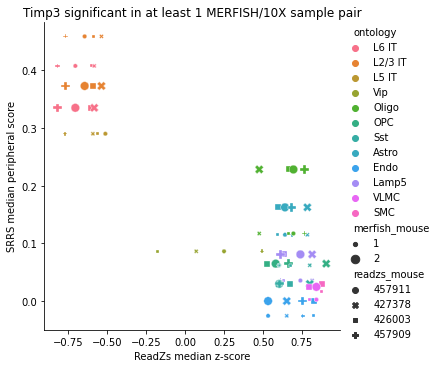

In [17]:
#Plot single gene

gene = 'Timp3'

sig_genes = corr_df[corr_df['significant']]['gene'].unique()

g = gene_sample_ontology_df[gene_sample_ontology_df['gene'].eq(gene)]

sig_title = 'significant in at least 1 MERFISH/10X sample pair' if gene in sig_genes else 'not significant'

g['readzs_mouse'] = g['readzs_mouse'].astype(str)
hue_order = g.groupby('ontology')['median_z_scaled'].mean().sort_values().index

fig = sns.relplot(
    x = 'median_z_scaled',
    y = 'med_score',
    hue = 'ontology',
    size = 'merfish_mouse',
    style = 'readzs_mouse',
    hue_order = hue_order,
    data = g,
)
plt.xlabel('ReadZs median z-score')
plt.ylabel('SRRS median peripheral score')
plt.title('{} '.format(gene)+sig_title)
plt.show(fig)
fig.savefig('timp3_peripheral_readzs_corrs.svg')

plt.close()


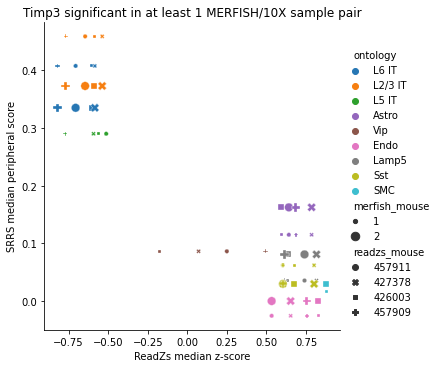

In [28]:
#Plot single gene

gene = 'Timp3'

sig_genes = corr_df[corr_df['significant']]['gene'].unique()

hue_order = ['L6 IT','L2/3 IT','L5 IT','Astro','Vip','Endo','Lamp5','Sst','SMC']
palette = ['#2777B4','#F67F11','#2EA02D','#9467BD','#8C564B','#E377C2','#7F7F7F','#BCBD22','#3EBECF']

g = gene_sample_ontology_df[gene_sample_ontology_df['gene'].eq(gene)]
g = g[g['ontology'].isin(hue_order)]

sig_title = 'significant in at least 1 MERFISH/10X sample pair' if gene in sig_genes else 'not significant'

g['readzs_mouse'] = g['readzs_mouse'].astype(str)
#hue_order = g.groupby('ontology')['median_z_scaled'].mean().sort_values().index

fig = sns.relplot(
    x = 'median_z_scaled',
    y = 'med_score',
    hue = 'ontology',
    size = 'merfish_mouse',
    style = 'readzs_mouse',
    hue_order = hue_order,
    palette = palette,
    data = g,
)
plt.xlabel('ReadZs median z-score')
plt.ylabel('SRRS median peripheral score')
plt.title('{} '.format(gene)+sig_title)
plt.show(fig)
fig.savefig('timp3_peripheral_readzs_corrs.svg')

plt.close()


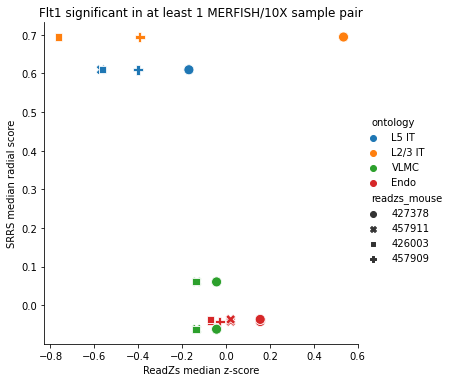

In [21]:
#Plot single gene

gene = 'Flt1'

sig_genes = corr_df[corr_df['significant']]['gene'].unique()

g = gene_sample_ontology_df[gene_sample_ontology_df['gene'].eq(gene)]

sig_title = 'significant in at least 1 MERFISH/10X sample pair' if gene in sig_genes else 'not significant'

g['readzs_mouse'] = g['readzs_mouse'].astype(str)
hue_order = g.groupby('ontology')['median_z_scaled'].mean().sort_values().index

fig = sns.relplot(
    x = 'median_z_scaled',
    y = 'med_score',
    hue = 'ontology',
    #size = 'merfish_mouse',
    s = 100,
    style = 'readzs_mouse',
    hue_order = hue_order,
    data = g,
)
plt.xlabel('ReadZs median z-score')
plt.ylabel('SRRS median radial score')
plt.title('{} '.format(gene)+sig_title)
plt.show(fig)
fig.savefig('flt1_peripheral_readzs_corrs.svg')

plt.close()


# 3' UTR level ReadZs correlations with MOp MERFISH

In [6]:
#Pull directly from gene_cell table because I want to collapse per mouse (2 mice total)
mop_df = pd.read_csv('../outputs/gene_cell/MOp_peripheral_ReadZs_gene_ontology.csv')

gb_cols = ['mouse','gene','ontology']

#filter SRRS results to
#1. Drop gene/cells which have fewer than 5 gene spots of interest
#2. Drop gene/cell-type/mouse with fewer than 20 cells
mop_df = mop_df[mop_df['num_gene_spots'].ge(5)]
mop_df = mop_df.groupby(gb_cols).filter(lambda g: len(g) >= 20)

#aggregate by mouse (over all slices)
#Calculate z from Lyapunov CLT for each gene in each sample
mop_agg_df = mop_df.groupby(gb_cols).agg(
    num_cells = ('cell_id','nunique'),
    num_slices = ('sample','nunique'),
    med_gene_spots = ('num_gene_spots','median'),
    med_spots = ('num_spots','median'),
    med_score = ('score','median'),
    score_sum = ('score','sum'),
    var_sum = ('variance','sum'),
).reset_index()

mop_agg_df['z'] = mop_agg_df['score_sum']/np.sqrt(mop_agg_df['var_sum'])

#Calculate two-sided p and BH correct ps
p_onesided = stats.norm.cdf(mop_agg_df['z'])
mop_agg_df['p'] = 2*np.minimum(p_onesided, 1-p_onesided)

alpha = 0.05

_,adj_p,_,_ = multitest.multipletests(
    mop_agg_df['p'],
    alpha = alpha,
    method = 'fdr_bh',
)
mop_agg_df['bh_p'] = adj_p
mop_agg_df = mop_agg_df.rename(columns={'mouse':'merfish_mouse'})

#read in the 10X ReadZs gene-level dataset without UNNANN filter
rz_10x_UTR_no_unann = pd.read_csv('../outputs/readzs/UTR_level/MOp_10Xv3_no_unann_filt.csv')
rz_10x_UTR_no_unann = rz_10x_UTR_no_unann.rename(columns={'mouse':'readzs_mouse'})

#merge the SRRS and ReadZs
m_UTR = mop_agg_df.merge(rz_10x_UTR_no_unann, on=['gene','ontology'])
m_UTR.head()

,merfish_mouse,gene,ontology,num_cells,num_slices,med_gene_spots,med_spots,med_score,score_sum,var_sum,...,med_counts_per_window_per_ont,median_z_scaled,chi2_p_val,perm_p_val,significant,medians_range,readzs_mouse,chr,strand,rz_bh_corrected
0,1,Adamts2,L2/3 IT,56,2,6.0,814.5,-0.271203,-10.749388,6.583127,...,1.0,-0.433910,1.0,1.0,NaN,1.285267e-01,427378,chr11,+,1.0
1,1,Adamts2,L2/3 IT,56,2,6.0,814.5,-0.271203,-10.749388,6.583127,...,1.0,-0.023016,1.0,1.0,NaN,3.910343e-01,457911,chr11,+,1.0
2,1,Adamts2,L2/3 IT,56,2,6.0,814.5,-0.271203,-10.749388,6.583127,...,1.0,-0.115272,1.0,1.0,NaN,9.714451e-17,426003,chr11,+,1.0
3,1,Adamts2,L2/3 IT,56,2,6.0,814.5,-0.271203,-10.749388,6.583127,...,1.0,-0.327033,1.0,1.0,NaN,3.994450e-01,457909,chr11,+,1.0
4,2,Adamts2,L2/3 IT,194,5,6.0,820.5,-0.185677,-30.205382,22.374981,...,1.0,-0.433910,1.0,1.0,NaN,1.285267e-01,427378,chr11,+,1.0


In [10]:
#calculate pearson correlations and BH corrected p-values
corr_data = collections.defaultdict(list)

#don't correlate ReadZs/SRRS gene/samples/mice with too few ontologies
gene_sample_ontology_df = (
    m_UTR.groupby([
        'gene',
        'merfish_mouse',
        'readzs_mouse'
    ]).filter(
        lambda g: g['ontology'].nunique() >= 2)
)

for (gene,merfish_mouse,readzs_mouse),g in gene_sample_ontology_df.groupby(['gene','merfish_mouse','readzs_mouse']):
    r,p = stats.pearsonr(g['med_score'],g['median_z_scaled'])
    
    corr_data['gene'].append(gene)
    corr_data['merfish_mouse'].append(merfish_mouse)
    corr_data['readzs_mouse'].append(readzs_mouse)
    corr_data['num_celltypes'].append(g['ontology'].nunique())
    corr_data['med_SRRS_cells_per_celltype'].append(g['num_cells'].median())
    corr_data['pearson_r'].append(r)
    corr_data['pearson_p'].append(p)

#BH multiple hypothesis correction for correlation p-values
corr_df = pd.DataFrame(corr_data).sort_values('pearson_p').dropna()
_,adj_p,_,_ = multitest.multipletests(
    corr_df['pearson_p'],
    alpha = 0.05,
    method = 'fdr_bh',
)

corr_df['bh_pearson_p'] = adj_p
corr_df['significant'] = corr_df['bh_pearson_p'].le(0.05)

corr_df

/home/users/rbierman/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


,gene,merfish_mouse,readzs_mouse,num_celltypes,med_SRRS_cells_per_celltype,pearson_r,pearson_p,bh_pearson_p,significant
710,Pdlim5,2,457909,2,349.5,-1.0,0.0,0.0,True
964,Sox10,1,457909,2,5079.0,1.0,0.0,0.0,True
968,Sox10,2,457909,2,4448.0,1.0,0.0,0.0,True
392,Fst,2,426003,2,985.5,-1.0,0.0,0.0,True
507,Lhx6,1,457909,2,2504.0,-1.0,0.0,0.0,True
...,...,...,...,...,...,...,...,...,...
238,Col23a1,2,426003,2,524.0,1.0,1.0,1.0,False
799,Ptger3,1,457911,2,25.5,-1.0,1.0,1.0,False
240,Col23a1,2,457909,2,524.0,-1.0,1.0,1.0,False
45,Barx2,1,457911,2,848.0,-1.0,1.0,1.0,False


In [11]:
corr_df['significant'].value_counts()

False    1031
True      155
Name: significant, dtype: int64

In [12]:
corr_df[corr_df['gene'].isin(['Flt1','Timp3'])]

,gene,merfish_mouse,readzs_mouse,num_celltypes,med_SRRS_cells_per_celltype,pearson_r,pearson_p,bh_pearson_p,significant
1066,Timp3,1,426003,12,356.0,-0.935853,1.934677e-11,1.274737e-09,True
1069,Timp3,1,457911,11,344.0,-0.922557,1.014393e-09,6.331947e-08,True
1067,Timp3,1,427378,10,220.5,-0.932788,2.079657e-09,1.233237e-07,True
1068,Timp3,1,457909,10,220.5,-0.914604,1.677022e-08,8.647599e-07,True
1070,Timp3,2,426003,10,420.0,-0.872057,5.434199e-07,2.148320e-05,True
1073,Timp3,2,457911,9,294.0,-0.822051,2.844988e-05,6.157412e-04,True
1071,Timp3,2,427378,8,205.0,-0.842924,4.131966e-05,8.597388e-04,True
368,Flt1,1,457909,3,45.0,-0.985423,3.171749e-04,4.455022e-03,True
1072,Timp3,2,457909,8,205.0,-0.771251,4.681632e-04,6.198127e-03,True
366,Flt1,1,426003,3,45.0,-0.996804,5.090952e-02,2.096482e-01,False


In [13]:
ind_cols = ['gene','merfish_mouse','readzs_mouse']
sig_inds = corr_df[corr_df['significant']].set_index(ind_cols).index
sig_gene_sample_ontology_df = gene_sample_ontology_df.set_index(ind_cols).loc[sig_inds].reset_index()
sig_gene_sample_ontology_df

,gene,merfish_mouse,readzs_mouse,ontology,num_cells,num_slices,med_gene_spots,med_spots,med_score,score_sum,...,sum_counts_per_window_per_ont,med_counts_per_window_per_ont,median_z_scaled,chi2_p_val,perm_p_val,significant,medians_range,chr,strand,rz_bh_corrected
0,Pdlim5,2,457909,Astro,598,5,6.0,207.5,-0.031100,-26.244144,...,24,1.0,-0.853174,0.0,0.0,True,1.976502,chr3,-,0.0
1,Pdlim5,2,457909,Astro,598,5,6.0,207.5,-0.031100,-26.244144,...,24,1.0,-0.853174,0.0,0.0,True,1.976502,chr3,-,0.0
2,Pdlim5,2,457909,Endo,101,3,5.0,189.0,-0.120690,-6.461117,...,27,2.0,-0.828835,0.0,0.0,True,1.976502,chr3,-,0.0
3,Pdlim5,2,457909,Endo,101,3,5.0,189.0,-0.120690,-6.461117,...,27,2.0,-0.828835,0.0,0.0,True,1.976502,chr3,-,0.0
4,Sox10,1,457909,OPC,2082,6,14.0,227.0,-0.046817,-114.221225,...,61,2.0,0.078711,0.0,0.0,True,0.703638,chr15,-,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2123,Camk2d,2,427378,Lamp5,413,6,10.0,605.0,0.005674,0.547866,...,3323,5.0,0.140856,0.0,0.0,True,1.713480,chr3,+,0.0
2124,Camk2d,2,427378,Sst,367,5,9.0,686.0,-0.068111,-7.754934,...,2850,4.0,0.125283,0.0,0.0,True,1.713480,chr3,+,0.0
2125,Camk2d,2,427378,Sst,367,5,9.0,686.0,-0.068111,-7.754934,...,2850,4.0,0.125283,0.0,0.0,True,1.713480,chr3,+,0.0
2126,Camk2d,2,427378,Vip,66,3,7.0,596.5,-0.060494,-2.935771,...,3352,3.0,-0.082791,0.0,0.0,True,1.713480,chr3,+,0.0


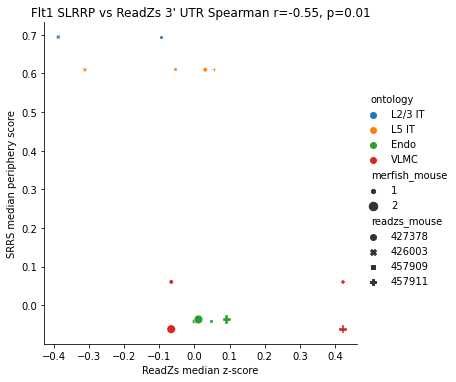

In [23]:
#single gene plot
gene = 'Flt1'

g = gene_sample_ontology_df[gene_sample_ontology_df['gene'].eq(gene)]

g['readzs_mouse'] = g['readzs_mouse'].astype(str)
hue_order = g.groupby('ontology')['median_z_scaled'].mean().sort_values().index
r,p = stats.spearmanr(g['median_z_scaled'],g['med_score'])

sns.relplot(
    x = 'median_z_scaled',
    y = 'med_score',
    hue = 'ontology',
    size = 'merfish_mouse',
    style = 'readzs_mouse',
    hue_order = hue_order,
    data = g,
)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('ReadZs median z-score')
plt.ylabel('SRRS median periphery score')
plt.title("{} SLRRP vs ReadZs 3' UTR Spearman r={:.2f}, p={:.2f}".format(gene,r,p))
plt.show()
plt.close()



In [27]:
#all correlation data on single plot

pdf = matplotlib.backends.backend_pdf.PdfPages("significant_UTR_srrs_10X_readzs_correlations_by_mouse_no_unann_filt.pdf")

sig_genes = sorted(corr_df[corr_df['significant']]['gene'].unique())
for gene in sig_genes:
    g = gene_sample_ontology_df[gene_sample_ontology_df['gene'].eq(gene)]
    g['readzs_mouse'] = g['readzs_mouse'].astype(str)
    hue_order = g.groupby('ontology')['median_z_scaled'].mean().sort_values().index
    r,p = stats.spearmanr(g['median_z_scaled'],g['med_score'])
    if p > 0.05:
        continue
    
    sns.relplot(
        x = 'median_z_scaled',
        y = 'med_score',
        hue = 'ontology',
        size = 'merfish_mouse',
        style = 'readzs_mouse',
        hue_order = hue_order,
        data = g,
    )
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('ReadZs median z-score')
    plt.ylabel('SRRS median periphery score')
    plt.title("{} SLRRP vs ReadZs 3' UTR Spearman r={:.2f}, p={:.2f}".format(gene,r,p))
    #plt.show()
    pdf.savefig(bbox_inches='tight')
    plt.close()

pdf.close()

In [29]:
print(sig_genes)

['Bcl11b', 'Bdnf', 'Calb2', 'Camk2d', 'Cbln2', 'Cbln4', 'Ccdc3', 'Cd24a', 'Cdh13', 'Chn2', 'Chrm2', 'Col25a1', 'Cux2', 'Cxcl14', 'Elfn1', 'Epha7', 'Fam84b', 'Fezf2', 'Flrt3', 'Flt1', 'Foxp2', 'Fst', 'Grik1', 'Grm1', 'Grm8', 'Igfbp4', 'Igfbp5', 'Inpp4b', 'Lhx6', 'Lsp1', 'Luzp2', 'Meis2', 'Nhs', 'Nkain3', 'Nos1', 'Nr4a2', 'Ntng2', 'Nxph1', 'Olfm3', 'Oprk1', 'Parm1', 'Pdlim5', 'Plcxd3', 'Pld5', 'Pou3f1', 'Ptprk', 'Ptprt', 'Ramp1', 'Reln', 'Rgs5', 'Rgs6', 'Rnf152', 'Rorb', 'Satb2', 'Slc17a6', 'Slc30a3', 'Sox10', 'Spon1', 'St6galnac5', 'Sulf2', 'Syt6', 'Thsd7a', 'Timp3', 'Trp53i11', 'Tunar', 'Unc13c', 'Unc5b', 'Ust', 'Vwc2', 'Wipf3']


In [18]:
g

,gene,merfish_mouse,readzs_mouse,ontology,num_cells,num_slices,med_gene_spots,med_spots,med_score,score_sum,...,sum_counts_per_window_per_ont,med_counts_per_window_per_ont,median_z_scaled,chi2_p_val,perm_p_val,significant,medians_range,chr,strand,rz_bh_corrected
28,Nhs,2,457911,L6b,44,2,6.0,649.5,0.061463,3.448710,...,162,2.0,0.006385,0.0,0.0,True,0.383234,chrX,-,0.0
29,Nhs,2,457911,L6b,44,2,6.0,649.5,0.061463,3.448710,...,162,2.0,0.006385,0.0,0.0,True,0.383234,chrX,-,0.0
30,Nhs,2,457911,Pvalb,283,5,6.0,978.0,-0.090244,-21.824095,...,482,3.0,0.050112,0.0,0.0,True,0.383234,chrX,-,0.0
31,Nhs,2,457911,Pvalb,283,5,6.0,978.0,-0.090244,-21.824095,...,482,3.0,0.050112,0.0,0.0,True,0.383234,chrX,-,0.0


(-1.0, 0.0)

## Window-level ReadZs from 10Xv3 sequencing correlations with MOp MERFISH

use the same SRRS_df from above, just correlate it to ReadZs windows instead of genes from the 10X data

In [3]:
#read in the 10X ReadZs window-level dataset
rz_10x = pd.read_csv('../outputs/readzs/window_level/MOp_10Xv3.csv')
rz_10x = rz_10x.rename(columns={'mouse':'readzs_mouse'})
rz_10x.head()

,window,ontology_mouse,sum_counts_per_window_per_ont,med_counts_per_window_per_ont,median_z_scaled,chi2_p_val,perm_p_val,significant,medians_range,ontology,readzs_mouse,chr,strand,bin_num,gene,rz_bh_corrected
0,chrX_32426_minus,Sst___427378,58,5.0,-0.446900,1.388166e-07,0.02,True,0.599749,Sst,427378,chrX,-,32426,Nhs,0.604545
1,chrX_32426_minus,Vip___427378,89,6.0,0.152849,1.388166e-07,0.02,True,0.599749,Vip,427378,chrX,-,32426,Nhs,0.604545
2,chrX_32397_plus,Vip___427378,61,6.0,-0.404210,5.492393e-02,1.00,NaN,0.561110,Vip,427378,chrX,+,32397,NaN,1.000000
3,chrX_32397_plus,Sst___427378,31,5.0,0.156900,5.492393e-02,1.00,NaN,0.561110,Sst,427378,chrX,+,32397,NaN,1.000000
4,chrX_32367_minus,L2/3 IT___427378,38,6.0,-0.235060,1.435780e-03,0.28,False,0.527298,L2/3 IT,427378,chrX,-,32367,Nhs,1.000000


In [4]:
#merge the SRRS and ReadZs
m = mop_agg_df.merge(rz_10x, on=['gene','ontology'])
m.head()

,merfish_mouse,gene,ontology,num_cells,num_slices,med_gene_spots,med_spots,med_score,score_sum,var_sum,...,median_z_scaled,chi2_p_val,perm_p_val,significant,medians_range,readzs_mouse,chr,strand,bin_num,rz_bh_corrected
0,1,Adamts2,L2/3 IT,56,2,6.0,814.5,-0.271203,-10.749388,6.583127,...,-0.086682,0.531317,1.0,NaN,0.233892,457911,chr11,+,10126,1.0
1,2,Adamts2,L2/3 IT,194,5,6.0,820.5,-0.185677,-30.205382,22.374981,...,-0.086682,0.531317,1.0,NaN,0.233892,457911,chr11,+,10126,1.0
2,1,Adamts2,L6 IT,137,3,6.0,727.0,-0.178947,-22.776114,15.504994,...,0.147210,0.531317,1.0,NaN,0.233892,457911,chr11,+,10126,1.0
3,2,Adamts2,L6 IT,169,4,7.0,740.0,-0.178832,-29.516926,17.427624,...,0.147210,0.531317,1.0,NaN,0.233892,457911,chr11,+,10126,1.0
4,1,Adamts4,L6 CT,86,3,6.0,506.0,0.195745,11.706821,10.155526,...,0.155153,0.804498,1.0,NaN,0.257201,457909,chr1,+,34253,1.0


In [5]:
#There can be multiple ReadZs windows in the same gene
display(rz_10x.shape)
display(mop_agg_df.shape)
display(m.shape)

(16049, 16)

(2514, 13)

(22693, 27)

In [6]:
#For each ReadZs window/merf-mouse/10x-mouse, I'll test whether the peripheral score of that gene 
#is correlated with the ReadZs score with pearson correlations and BH corrected p-values
corr_data = collections.defaultdict(list)

#don't correlate ReadZs windows with too few ontologies
gene_sample_ontology_df = (
    m.groupby([
        'window',
        'merfish_mouse',
        'readzs_mouse'
    ]).filter(
        lambda g: g['ontology'].nunique() >= 5)
)

for (window,merfish_mouse,readzs_mouse),g in gene_sample_ontology_df.groupby(['window','merfish_mouse','readzs_mouse']):
    r,p = stats.pearsonr(g['med_score'],g['median_z_scaled'])
    gene = g['gene'].unique()[0] #all will have the same gene
    
    corr_data['window'].append(window)
    corr_data['gene'].append(gene)
    corr_data['merfish_mouse'].append(merfish_mouse)
    corr_data['readzs_mouse'].append(readzs_mouse)
    corr_data['num_celltypes'].append(g['ontology'].nunique())
    corr_data['med_SRRS_cells_per_celltype'].append(g['num_cells'].median())
    corr_data['pearson_r'].append(r)
    corr_data['pearson_p'].append(p)

#BH multiple hypothesis correction for correlation p-values
corr_df = pd.DataFrame(corr_data).sort_values('pearson_p')
_,adj_p,_,_ = multitest.multipletests(
    corr_df['pearson_p'],
    alpha = 0.05,
    method = 'fdr_bh',
)

corr_df['bh_pearson_p'] = adj_p
corr_df['significant'] = corr_df['bh_pearson_p'].le(0.05)

corr_df

,window,gene,merfish_mouse,readzs_mouse,num_celltypes,med_SRRS_cells_per_celltype,pearson_r,pearson_p,bh_pearson_p,significant
986,chr7_22809_plus,Spon1,1,457909,6,2001.0,-0.986710,3.193009e-09,0.000003,True
989,chr7_22809_plus,Spon1,2,427378,7,1517.0,-0.903706,9.326737e-06,0.003532,True
509,chr18_17344_plus,Cbln2,2,457911,6,2165.0,0.932436,9.892198e-06,0.003532,True
990,chr7_22809_plus,Spon1,2,457909,6,1558.0,-0.896414,7.875413e-05,0.018247,True
508,chr18_17344_plus,Cbln2,2,457909,7,1849.0,0.858397,8.518500e-05,0.018247,True
...,...,...,...,...,...,...,...,...,...,...
1021,chr8_5842_minus,Unc5d,1,427378,5,1786.0,0.006458,9.917772e-01,0.995207,False
890,chr6_5462_minus,Grm8,1,426003,5,5317.0,-0.005954,9.924190e-01,0.995207,False
817,chr4_5775_plus,Epha7,2,457911,6,3764.0,-0.003932,9.941014e-01,0.995584,False
872,chr6_10861_plus,Chn2,2,427378,6,120.5,0.003564,9.946545e-01,0.995584,False


In [7]:
#there are only 7 window/Merfish-mouse/ReadZs-mouse groups with significant correlation after BH
#only four genes Spon1/Cbln2/Grm1/Cdh12
#
#from gene-level the genes were
#array(['Timp3', 'Cbln2', 'Ptpru', 'Itgb8', 'Ubash3b', 'Rgs5', 'Cobll1',
#       'Ntng2'], dtype=object)
#
# only Cbln2 is found to be significantly correlated between SRRS/ReadZs in both
#

corr_df[corr_df['significant']]

,window,gene,merfish_mouse,readzs_mouse,num_celltypes,med_SRRS_cells_per_celltype,pearson_r,pearson_p,bh_pearson_p,significant
986,chr7_22809_plus,Spon1,1,457909,6,2001.0,-0.986710,3.193009e-09,0.000003,True
989,chr7_22809_plus,Spon1,2,427378,7,1517.0,-0.903706,9.326737e-06,0.003532,True
509,chr18_17344_plus,Cbln2,2,457911,6,2165.0,0.932436,9.892198e-06,0.003532,True
990,chr7_22809_plus,Spon1,2,457909,6,1558.0,-0.896414,7.875413e-05,0.018247,True
508,chr18_17344_plus,Cbln2,2,457909,7,1849.0,0.858397,8.518500e-05,0.018247,True
10,chr10_2138_minus,Grm1,1,457909,7,1279.0,-0.833519,2.125643e-04,0.037943,True
370,chr15_4174_plus,Cdh12,1,457911,7,2913.0,0.970468,2.833130e-04,0.043347,True


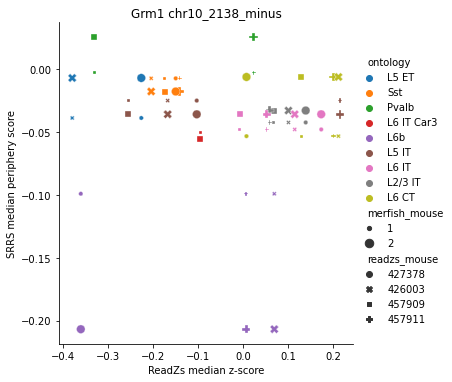

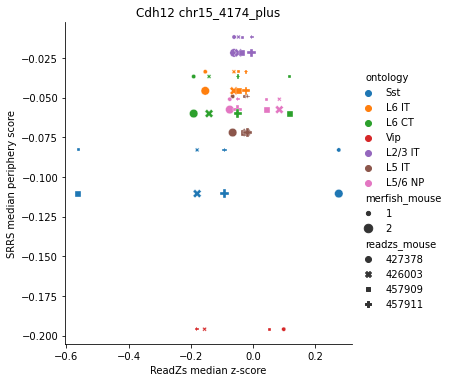

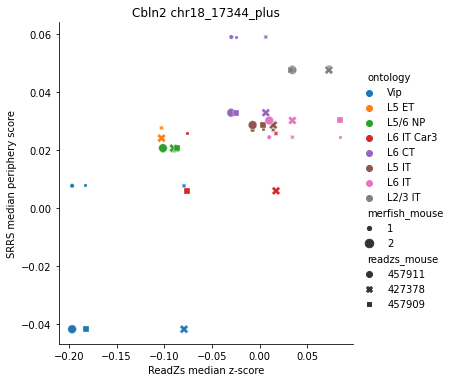

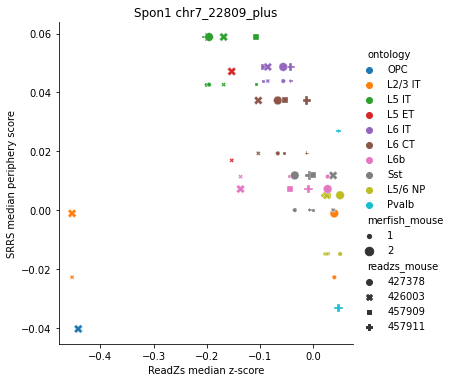

In [8]:
sig_windows = corr_df[corr_df['significant']]['window'].unique()

sig_gene_sample_ontology_df = gene_sample_ontology_df[
    gene_sample_ontology_df['window'].isin(sig_windows)
]

#all correlation data on single plot
#pdf = matplotlib.backends.backend_pdf.PdfPages("significant_srrs_10X_readzs_correlations_by_mouse_windows.pdf")

for window,g in sig_gene_sample_ontology_df.groupby('window'):
    gene = g['gene'].unique()[0] #all will have the same gene
    g['readzs_mouse'] = g['readzs_mouse'].astype(str)
    hue_order = g.groupby('ontology')['median_z_scaled'].mean().sort_values().index
    
    sns.relplot(
        x = 'median_z_scaled',
        y = 'med_score',
        hue = 'ontology',
        size = 'merfish_mouse',
        style = 'readzs_mouse',
        hue_order = hue_order,
        data = g,
    )
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('ReadZs median z-score')
    plt.ylabel('SRRS median periphery score')
    plt.title('{} {}'.format(gene,window))
    plt.show()
    #pdf.savefig(bbox_inches='tight')
    plt.close()

#pdf.close()

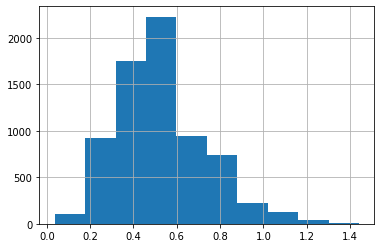

In [10]:
gene_sample_ontology_df['window_readzs_span'] = (
    gene_sample_ontology_df
        .groupby('window')['median_z_scaled']
        .transform(lambda v: v.max()-v.min())
)

gene_sample_ontology_df['window_readzs_span'].hist()
plt.show()
plt.close()

In [11]:
#Plot all windows, not just the significant ones

sig_windows = corr_df[corr_df['significant']]['window'].unique()

#all correlation data on single plot
pdf = matplotlib.backends.backend_pdf.PdfPages("all_peripheral_srrs_10X_readzs_correlations_by_mouse_windows.pdf")

for window,g in gene_sample_ontology_df[gene_sample_ontology_df['window_readzs_span'].ge(0.6)].groupby('window'):
    sig_str = 'significant in at least one sample pair' if window in sig_windows else 'not significant'
    
    gene = g['gene'].unique()[0] #all will have the same gene
    g['readzs_mouse'] = g['readzs_mouse'].astype(str)
    hue_order = g.groupby('ontology')['median_z_scaled'].mean().sort_values().index
    
    sns.relplot(
        x = 'median_z_scaled',
        y = 'med_score',
        hue = 'ontology',
        size = 'merfish_mouse',
        style = 'readzs_mouse',
        hue_order = hue_order,
        data = g,
    )
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('ReadZs median z-score')
    plt.ylabel('SRRS median periphery score')
    plt.title('{} ({}) {}'.format(gene,window,sig_str))
    #plt.show()
    pdf.savefig(bbox_inches='tight')
    plt.close()

pdf.close()

# Gene-level ReadZs SS2 correlations with SRRS MOp

Can use the same SRRS table generated above for the 10X ReadZs comparisons since the cell-types are the same

In [10]:
rz_ss2 = pd.read_csv('../outputs/readzs/gene_level/MOp_SS2.csv')
rz_ss2.head()

,gene,window,ontology,sum_counts_per_window_per_ont,med_counts_per_window_per_ont,median_z_scaled,chi2_p_val,perm_p_val,significant,medians_range,rz_bh_corrected
0,Pxdc1,chr13_Pxdc1,Sncg,523,12.0,-0.188515,0.0,0.0,True,1.986624,0.0
1,Pxdc1,chr13_Pxdc1,Pvalb,1678,12.0,-0.096740,0.0,0.0,True,1.986624,0.0
2,Pxdc1,chr13_Pxdc1,Vip,16511,31.0,-0.094528,0.0,0.0,True,1.986624,0.0
3,Pxdc1,chr13_Pxdc1,Sst,17065,23.0,-0.093417,0.0,0.0,True,1.986624,0.0
4,Pxdc1,chr13_Pxdc1,L5 IT,3232,12.0,-0.076602,0.0,0.0,True,1.986624,0.0


In [11]:
rz_ss2['gene'].eq('Flt1').any()

True

In [12]:
#merge the SRRS and ReadZs
m = mop_agg_df.merge(rz_ss2, on=['gene','ontology'])
m.head()

,merfish_mouse,gene,ontology,num_cells,num_slices,med_gene_spots,med_spots,med_score,score_sum,var_sum,...,bh_p,window,sum_counts_per_window_per_ont,med_counts_per_window_per_ont,median_z_scaled,chi2_p_val,perm_p_val,significant,medians_range,rz_bh_corrected
0,1,Acta2,L2/3 IT,991,5,5.0,695.0,0.102431,91.602118,122.242160,...,8.804734e-16,chr19_Acta2,156,2.0,-0.245706,0.0,0.0,True,1.211264,0.0
1,2,Acta2,L2/3 IT,24,1,5.0,934.0,0.030987,2.560018,3.137224,...,1.939587e-01,chr19_Acta2,156,2.0,-0.245706,0.0,0.0,True,1.211264,0.0
2,1,Acta2,L5 IT,817,5,6.0,836.0,0.125850,92.051336,97.079655,...,0.000000e+00,chr19_Acta2,761,5.0,0.146247,0.0,0.0,True,1.211264,0.0
3,1,Acta2,L6 CT,265,3,5.0,516.0,0.176113,39.580953,33.029954,...,1.891902e-11,chr19_Acta2,464,1.0,0.262013,0.0,0.0,True,1.211264,0.0
4,1,Acta2,L6 IT,448,5,5.0,781.5,0.167048,69.549196,54.999854,...,0.000000e+00,chr19_Acta2,68,2.0,-0.399946,0.0,0.0,True,1.211264,0.0


In [13]:
#calculate pearson correlations and BH corrected p-values
corr_data = {
    'gene':[],
    'merfish_mouse':[],
    'num_celltypes':[],
    'med_SRRS_cells_per_celltype':[],
    'pearson_r':[],
    'pearson_p':[],
}

#can't correlate ReadZs/SRRS gene/samples with only a single ontology
gene_sample_ontology_df = m.groupby(['gene','merfish_mouse']).filter(lambda g: g['ontology'].nunique() >= 2)

for (gene,sample_name),g in gene_sample_ontology_df.groupby(['gene','merfish_mouse']):
    r,p = stats.pearsonr(g['med_score'],g['median_z_scaled'])
    
    corr_data['gene'].append(gene)
    corr_data['merfish_mouse'].append(sample_name)
    corr_data['num_celltypes'].append(g['ontology'].nunique())
    corr_data['med_SRRS_cells_per_celltype'].append(g['num_cells'].median())
    corr_data['pearson_r'].append(r)
    corr_data['pearson_p'].append(p)

#BH multiple hypothesis correction
corr_df = pd.DataFrame(corr_data).sort_values('pearson_p')
_,adj_p,_,_ = multitest.multipletests(
    corr_df['pearson_p'],
    alpha = 0.05,
    method = 'fdr_bh',
)

corr_df['bh_pearson_p'] = adj_p
corr_df['significant'] = corr_df['bh_pearson_p'].le(0.05)

corr_df

,gene,merfish_mouse,num_celltypes,med_SRRS_cells_per_celltype,pearson_r,pearson_p,bh_pearson_p,significant
129,Grm8,1,10,1892.0,-0.933785,0.000078,0.026462,True
183,Nr4a1,1,10,1900.0,0.889678,0.000566,0.096529,False
176,Nos1,2,6,392.0,0.965650,0.001750,0.154258,False
199,Parm1,2,10,1095.5,0.844607,0.002105,0.154258,False
49,Cd24a,2,5,191.0,0.980638,0.003225,0.154258,False
...,...,...,...,...,...,...,...,...
117,Fst,2,2,985.5,1.000000,1.000000,1.000000,False
116,Fst,1,2,1163.0,-1.000000,1.000000,1.000000,False
111,Flt1,2,2,1222.5,1.000000,1.000000,1.000000,False
234,Ptger3,2,2,26.5,-1.000000,1.000000,1.000000,False


In [14]:
#only Grm8 is significant
corr_df[corr_df['significant']]

,gene,merfish_mouse,num_celltypes,med_SRRS_cells_per_celltype,pearson_r,pearson_p,bh_pearson_p,significant
129,Grm8,1,10,1892.0,-0.933785,0.000078,0.026462,True


In [27]:
sig_genes = corr_df[corr_df['significant']]['gene'].unique()

sig_gene_sample_ontology_df = gene_sample_ontology_df[
    gene_sample_ontology_df['gene'].isin(sig_genes)
]

#all correlation data on single plot
#pdf = matplotlib.backends.backend_pdf.PdfPages("significant_srrs_SS2_readzs_correlations_by_mouse_genes.pdf")

for gene,g in sig_gene_sample_ontology_df.groupby('gene'):
    hue_order = g.groupby('ontology')['median_z_scaled'].mean().sort_values().index
    
    sns.relplot(
        x = 'median_z_scaled',
        y = 'med_score',
        hue = 'ontology',
        style = 'merfish_mouse',
        hue_order = hue_order,
        data = g,
    )
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('ReadZs median z-score')
    plt.ylabel('SRRS median periphery score')
    plt.title('{}'.format(gene))
    plt.show()
    #pdf.savefig(bbox_inches='tight')
    plt.close()

#pdf.close()

In [28]:
#Flt1 not found in 10X data
#Previously it WAS found
#DIFFERENCE WAS THAT Flt1 is a minus-strand gene, but the significant bin was the plus strand
rz_10x['gene'].eq('Flt1').any()

False

In [15]:
#Flt1 found in SS2 (unstranded) but not significant
rz_ss2[rz_ss2['gene'].eq('Flt1')]

,gene,window,ontology,sum_counts_per_window_per_ont,med_counts_per_window_per_ont,median_z_scaled,chi2_p_val,perm_p_val,significant,medians_range,rz_bh_corrected
336,Flt1,chr5_Flt1,Lamp5,71,2.0,-0.599768,1.324658e-09,0.34,False,1.056614,0.408687
337,Flt1,chr5_Flt1,Endo,14835,862.0,0.026730,1.324658e-09,0.34,False,1.056614,0.408687
338,Flt1,chr5_Flt1,L6b,679,2.0,0.060212,1.324658e-09,0.34,False,1.056614,0.408687
339,Flt1,chr5_Flt1,L5 IT,329,1.0,0.167881,1.324658e-09,0.34,False,1.056614,0.408687
340,Flt1,chr5_Flt1,L6 IT,162,1.0,0.176370,1.324658e-09,0.34,False,1.056614,0.408687
341,Flt1,chr5_Flt1,Sst,128,2.0,0.176800,1.324658e-09,0.34,False,1.056614,0.408687
342,Flt1,chr5_Flt1,L6 CT,416,1.0,0.181648,1.324658e-09,0.34,False,1.056614,0.408687
343,Flt1,chr5_Flt1,L5/6 NP,35,1.0,0.183569,1.324658e-09,0.34,False,1.056614,0.408687
344,Flt1,chr5_Flt1,Pvalb,32,1.0,0.183784,1.324658e-09,0.34,False,1.056614,0.408687
345,Flt1,chr5_Flt1,L2/3 IT,64,1.0,0.185289,1.324658e-09,0.34,False,1.056614,0.408687


In [18]:
gene_sample_ontology_df[gene_sample_ontology_df['gene'].eq(gene)]

,merfish_mouse,gene,ontology,num_cells,num_slices,med_gene_spots,med_spots,med_score,score_sum,var_sum,...,bh_p,window,sum_counts_per_window_per_ont,med_counts_per_window_per_ont,median_z_scaled,chi2_p_val,perm_p_val,significant,medians_range,rz_bh_corrected
633,1,Flt1,Endo,2140,6,29.0,155.0,-0.042081,-94.173397,64.046880,...,2.671619e-31,chr5_Flt1,14835,862.0,0.026730,1.324658e-09,0.34,False,1.056614,0.408687
634,2,Flt1,Endo,1517,6,29.0,153.0,-0.036585,-65.791544,45.068126,...,4.853192e-22,chr5_Flt1,14835,862.0,0.026730,1.324658e-09,0.34,False,1.056614,0.408687
635,1,Flt1,L2/3 IT,22,1,6.0,628.0,0.694375,12.699482,2.554645,...,7.741111e-15,chr5_Flt1,64,1.0,0.185289,1.324658e-09,0.34,False,1.056614,0.408687
636,1,Flt1,L5 IT,45,2,7.0,708.0,0.609618,22.350518,4.558263,...,0.000000e+00,chr5_Flt1,329,1.0,0.167881,1.324658e-09,0.34,False,1.056614,0.408687
637,1,Flt1,SMC,1317,6,15.0,329.0,-0.014587,9.717386,82.417629,...,3.467988e-01,chr5_Flt1,1036,32.0,0.456846,1.324658e-09,0.34,False,1.056614,0.408687
638,2,Flt1,SMC,928,6,14.0,329.5,-0.008775,15.245041,59.190262,...,6.812515e-02,chr5_Flt1,1036,32.0,0.456846,1.324658e-09,0.34,False,1.056614,0.408687


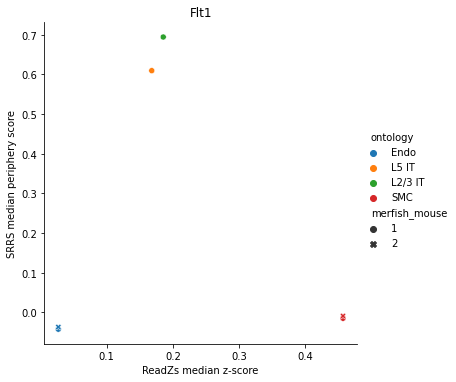

In [20]:
#Hand-plotting genes of interest for ss2

#all correlation data on single plot
#pdf = matplotlib.backends.backend_pdf.PdfPages("significant_srrs_SS2_readzs_correlations_by_mouse_genes.pdf")
gene = 'Flt1'
g = gene_sample_ontology_df[gene_sample_ontology_df['gene'].eq(gene)]
hue_order = g.groupby('ontology')['median_z_scaled'].mean().sort_values().index

sns.relplot(
    x = 'median_z_scaled',
    y = 'med_score',
    hue = 'ontology',
    style = 'merfish_mouse',
    hue_order = hue_order,
    data = g,
)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('ReadZs median z-score')
plt.ylabel('SRRS median periphery score')
plt.title('{}'.format(gene))
plt.show()
#pdf.savefig(bbox_inches='tight')
plt.close()

In [30]:
#seeing if Timp3 was nearly significant in SS2 ReadZs correlations (yes before BH)
corr_df[corr_df['gene'].eq('Timp3')]

,gene,merfish_mouse,num_celltypes,med_SRRS_cells_per_celltype,pearson_r,pearson_p,bh_pearson_p,significant
308,Timp3,1,10,232.5,-0.723519,0.018021,0.349427,False
309,Timp3,2,8,670.5,-0.716322,0.045618,0.454956,False


In [27]:
tenX_ann = pd.read_csv('/scratch/groups/horence/rob/data/MERFISH_scRNAseq/10X.cell.cluster.annotation.csv')
tenX_ann = tenX_ann[tenX_ann['subclass_label'].eq('Oligo')]

tenX_mem = pd.read_csv('/scratch/groups/horence/rob/data/MERFISH_scRNAseq/10X.cell.cluster.membership.csv')
tenX_ann.merge(tenX_mem,left_on='cluster_id',right_on='x')

,cluster_id,cluster_label,subclass_label,class_label,cluster_color,size,Unnamed: 0,x
0,71,Oligo Enpp6_1,Oligo,Non-Neuronal,#6B998D,38,TGTACAGTCAGCTGTA-1L8TX_181211_01_G12,71
1,71,Oligo Enpp6_1,Oligo,Non-Neuronal,#6B998D,38,TGTGGCGCATCCGCGA-1L8TX_181211_01_G12,71
2,71,Oligo Enpp6_1,Oligo,Non-Neuronal,#6B998D,38,GGGTGAATCTGAACGT-2L8TX_181211_01_H12,71
3,71,Oligo Enpp6_1,Oligo,Non-Neuronal,#6B998D,38,TTTCAGTTCTCAACCC-2L8TX_181211_01_H12,71
4,71,Oligo Enpp6_1,Oligo,Non-Neuronal,#6B998D,38,ATGGATCAGCGAGGAG-3L8TX_181211_01_A01,71
...,...,...,...,...,...,...,...,...
532,74,Oligo Opalin_2,Oligo,Non-Neuronal,#478662,92,TACGGGCTCTGTGCTC-12L8TX_190430_01_G08,74
533,74,Oligo Opalin_2,Oligo,Non-Neuronal,#478662,92,TACGTCCGTGTCACAT-12L8TX_190430_01_G08,74
534,74,Oligo Opalin_2,Oligo,Non-Neuronal,#478662,92,TCAAGTGCATCCTGTC-12L8TX_190430_01_G08,74
535,74,Oligo Opalin_2,Oligo,Non-Neuronal,#478662,92,TTCCACGAGATGCGAC-12L8TX_190430_01_G08,74


In [30]:
tenX_ann = pd.read_csv('/oak/stanford/groups/horence/rob/readzs_fork/MOp_10Xv3_metadata.tsv',sep='\t')
tenX_ann[tenX_ann['subclass_label'].eq('Oligo')]

,cell_id,cluster_id,library,cell_bc,cluster_label,subclass_label,class_label,cluster_color,size
39239,L8TX_181211_01_G12_AAACGCTGTATCGAGG,73,L8TX_181211_01_G12,AAACGCTGTATCGAGG,Oligo Opalin_1,Oligo,Non-Neuronal,#474662,375
39240,L8TX_181211_01_G12_AACCATGAGGTGCATG,73,L8TX_181211_01_G12,AACCATGAGGTGCATG,Oligo Opalin_1,Oligo,Non-Neuronal,#474662,375
39241,L8TX_181211_01_G12_ACAGGGACACGGGTAA,73,L8TX_181211_01_G12,ACAGGGACACGGGTAA,Oligo Opalin_1,Oligo,Non-Neuronal,#474662,375
39242,L8TX_181211_01_G12_AGAGCCCAGCCTCTGG,73,L8TX_181211_01_G12,AGAGCCCAGCCTCTGG,Oligo Opalin_1,Oligo,Non-Neuronal,#474662,375
39243,L8TX_181211_01_G12_AGGAATAGTGATGGCA,73,L8TX_181211_01_G12,AGGAATAGTGATGGCA,Oligo Opalin_1,Oligo,Non-Neuronal,#474662,375
...,...,...,...,...,...,...,...,...,...
70667,L8TX_190430_01_G08_GTGTTCCTCCACAAGT,71,L8TX_190430_01_G08,GTGTTCCTCCACAAGT,Oligo Enpp6_1,Oligo,Non-Neuronal,#6B998D,38
70668,L8TX_190430_01_G08_GTTGTAGGTCCATAGT,71,L8TX_190430_01_G08,GTTGTAGGTCCATAGT,Oligo Enpp6_1,Oligo,Non-Neuronal,#6B998D,38
70669,L8TX_190430_01_G08_TAACGACTCGGAAGGT,71,L8TX_190430_01_G08,TAACGACTCGGAAGGT,Oligo Enpp6_1,Oligo,Non-Neuronal,#6B998D,38
70670,L8TX_190430_01_G08_TGAGCGCGTGCTGCAC,71,L8TX_190430_01_G08,TGAGCGCGTGCTGCAC,Oligo Enpp6_1,Oligo,Non-Neuronal,#6B998D,38


In [31]:
ss2_ann = pd.read_csv('/oak/stanford/groups/horence/rob/readzs_fork/MOp_SS2_metadata.tsv',sep='\t')
ss2_ann[tenX_ann['subclass_label'].eq('Oligo')]

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,cell_id,cluster_id,cluster_label,subclass_label,class_label,cluster_color,size
